In [56]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

folder_path = 'genres_original'

def load_audio_files(folder_path):
    audio_files = []
    for genre in os.listdir(folder_path):
        genre_folder = os.path.join(folder_path, genre)
        if os.path.isdir(genre_folder):
            for file in os.listdir(genre_folder):
                if file.endswith('.wav'):
                    audio_files.append(os.path.join(genre_folder, file))
    return audio_files





In [57]:
def calculate_zero_crossing_rate(y):
    """
    Calculate the Zero-Crossing Rate of an audio signal.
    
    Parameters:
        y (numpy.ndarray): Audio time-series signal.
    
    Returns:
        zcr (float): Zero-Crossing Rate.
    """
    # Count the number of times the signal changes sign
    zero_crossings = np.sum(np.abs(np.diff(np.sign(y)))) / 2
    # Normalize by the total number of samples
    zcr = zero_crossings / len(y)
    return zcr


def calculate_temporal_centroid(y, sr):
    """
    Calculate the Temporal Centroid of an audio signal.
    
    Parameters:
        y (numpy.ndarray): Audio time-series signal.
        sr (int): Sampling rate of the audio.
    
    Returns:
        temporal_centroid (float): Temporal Centroid in seconds.
    """
    # Compute the squared signal (energy at each sample)
    energy = y ** 2
    # Generate a time array corresponding to each sample
    time = np.arange(len(y)) / sr
    # Compute the Temporal Centroid
    temporal_centroid = np.sum(time * energy) / np.sum(energy)
    return temporal_centroid

def calculate_energy_fft(y, sr):
    """
    Calculate the energy of an audio signal across bass, midrange, and treble frequencies using the Fourier Transform.
    
    Parameters:
        y (numpy.ndarray): Audio time-series signal.
        sr (int): Sampling rate of the audio.
    
    Returns:
        energy_distribution (dict): Dictionary containing the energy of bass, midrange, and treble frequency bands.
    """
    # Perform the Fourier Transform
    yf = np.fft.fft(y)
    # Compute the power spectrum
    psd = np.abs(yf) ** 2
    # Compute the frequencies corresponding to the FFT
    freqs = np.fft.fftfreq(len(y), 1 / sr)
    
    # Define frequency ranges for bass, midrange, and treble
    bass_range = (0, 250)  # Bass: 0-250 Hz
    midrange_range = (250, 4000)  # Midrange: 250-4000 Hz
    treble_range = (4000, sr / 2)  # Treble: 4000 Hz to Nyquist frequency
    
    # Calculate energy for each range
    bass_energy = np.sum(psd[(freqs >= bass_range[0]) & (freqs < bass_range[1])]) / len(psd)
    midrange_energy = np.sum(psd[(freqs >= midrange_range[0]) & (freqs < midrange_range[1])]) / len(psd)
    treble_energy = np.sum(psd[(freqs >= treble_range[0]) & (freqs < treble_range[1])]) / len(psd)
    
    # Return energy distribution
    energy_distribution = {
        "bass": bass_energy,
        "midrange": midrange_energy,
        "treble": treble_energy
    }
    
    return energy_distribution

def calculate_spectral_bandwidth(y, sr):
    """
    Calculate the Spectral Bandwidth of an audio signal.
    
    Parameters:
        y (numpy.ndarray): Audio time-series signal.
        sr (int): Sampling rate of the audio.
    
    Returns:
        spectral_bandwidth (float): Spectral Bandwidth in Hz.
    """
    # Perform FFT and calculate the magnitude spectrum
    fft_spectrum = np.fft.fft(y)
    magnitude_spectrum = np.abs(fft_spectrum[:len(fft_spectrum) // 2])
    
    # Compute the corresponding frequency array
    freqs = np.fft.fftfreq(len(y), d=1/sr)[:len(fft_spectrum) // 2]
    
    # Compute the Spectral Centroid
    spectral_centroid = np.sum(freqs * magnitude_spectrum) / np.sum(magnitude_spectrum)
    
    # Compute the Spectral Bandwidth
    spectral_bandwidth = np.sqrt(np.sum((freqs - spectral_centroid)**2 * magnitude_spectrum) / np.sum(magnitude_spectrum))
    
    return spectral_bandwidth

def calculate_spectral_rolloff(y, sr, rolloff_percent=0.85):
    """
    Calculate the Spectral Rolloff of an audio signal.
    
    Parameters:
        y (numpy.ndarray): Audio time-series signal.
        sr (int): Sampling rate of the audio.
        rolloff_percent (float): Percentage of total energy to calculate rolloff (default: 0.85).
    
    Returns:
        spectral_rolloff (float): Spectral Rolloff frequency in Hz.
    """
    # Perform FFT and calculate the magnitude spectrum
    fft_spectrum = np.fft.fft(y)
    magnitude_spectrum = np.abs(fft_spectrum[:len(fft_spectrum) // 2])
    
    # Compute the corresponding frequency array
    freqs = np.fft.fftfreq(len(y), d=1/sr)[:len(fft_spectrum) // 2]
    
    # Compute the cumulative sum of the spectrum
    cumulative_energy = np.cumsum(magnitude_spectrum)
    
    # Find the rolloff frequency where the cumulative energy reaches the specified percentage
    total_energy = cumulative_energy[-1]
    rolloff_threshold = rolloff_percent * total_energy
    rolloff_index = np.where(cumulative_energy >= rolloff_threshold)[0][0]
    
    # Get the corresponding frequency
    spectral_rolloff = freqs[rolloff_index]
    
    return spectral_rolloff

def calculate_mfcc(y, sr, n_mfcc=13):
    """
    Calculate the Mel-Frequency Cepstral Coefficients (MFCCs) of an audio signal.
    
    Parameters:
        y (numpy.ndarray): Audio time-series signal.
        sr (int): Sampling rate of the audio.
        n_mfcc (int): Number of MFCCs to calculate (default: 13).
    
    Returns:
        mfccs (numpy.ndarray): Matrix of MFCCs.
    """
    
    # Extract the MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract 13 MFCCs
    
    return mfccs

def extract_tonal_centroid(y, sr):
    """
    Extract Tonal Centroid Features (Tonnetz) from an audio file.
    
    Parameters:
        file_path (str): Path to the audio file.
        sr (int): Sampling rate. Default is 22050 Hz.
    
    Returns:
        tonal_centroid (numpy.ndarray): Tonal centroid features (shape: 6 x frames).
    """
    
    # Compute Chroma Features
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
    
    # Compute Tonnetz (Tonal Centroid Features)
    tonal_centroid = librosa.feature.tonnetz(chroma=chroma, sr=sr)
    
    return tonal_centroid

In [ ]:
from scipy.signal import butter, lfilter
from scipy.fft import fft


def extract_features_simple(file_path):
        y, sr = librosa.load(file_path, sr=None)  # Load the audio file
        # Extract zero crossing rate from this signal using scipy

        #Extract the genre from the file path
        genre = file_path.split('/')[1]
        zero_crossing_rate = calculate_zero_crossing_rate(y)


        # Calculate the energy using the Fourier Transform
        energy_fft = calculate_energy_fft(y, sr)

        #extract tempo of the song
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

        #calculate speactral bandwidth
        spectral_bandwidth = calculate_spectral_bandwidth(y, sr)
        spectral_rolloff = calculate_spectral_rolloff(y, sr, rolloff_percent=0.85)

        # Calculate the MFCCs
        mfccs = calculate_mfcc(y, sr)

        #calculate tonal centroid
        tonal_centroid = extract_tonal_centroid(y, sr)
        tonal_centroid_mean = np.mean(tonal_centroid, axis=1)
        tonal_centroid_std = np.std(tonal_centroid, axis=1)



        # Summarize MFCCs (e.g., mean and standard deviation)
        mfcc_mean = np.mean(mfccs, axis=1)
        mfcc_std = np.std(mfccs, axis=1)

        #Chroma feature extraction
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        chroma_std = np.std(chroma, axis=1)

      
        #Create a dataframe with this information
        features = {
            "zero_crossing_rate": zero_crossing_rate,
            "tempo": int(tempo[0]),
            "spectral_bandwidth": spectral_bandwidth,
            "spectral_rolloff": spectral_rolloff,
            **energy_fft,
            "genre": genre,
            **{f"mfcc_{i}_mean": value for i, value in enumerate(mfcc_mean)},
            **{f"mfcc_{i}_std": value for i, value in enumerate(mfcc_std)},
            **{f"chroma_{i}_mean": value for i, value in enumerate(chroma_mean)},
            **{f"chroma_{i}_std": value for i, value in enumerate(chroma_std)},
            **{f"tonal_centroid_{i}_mean": value for i, value in enumerate(tonal_centroid_mean)},
            **{f"tonal_centroid_{i}_std": value for i, value in enumerate(tonal_centroid_std)}
        }

        return features


{'zero_crossing_rate': np.float32(0.056117162), 'tempo': 107, 'spectral_bandwidth': np.float64(2270.4564017016405), 'spectral_rolloff': np.float64(4139.59351399378), 'bass': np.float32(2018.5044), 'midrange': np.float32(1778.1461), 'treble': np.float32(35.773125), 'genre': 'blues', 'mfcc_0_mean': np.float32(-207.52383), 'mfcc_1_mean': np.float32(123.98514), 'mfcc_2_mean': np.float32(8.94702), 'mfcc_3_mean': np.float32(35.86715), 'mfcc_4_mean': np.float32(2.9095948), 'mfcc_5_mean': np.float32(21.519472), 'mfcc_6_mean': np.float32(-8.556513), 'mfcc_7_mean': np.float32(23.370676), 'mfcc_8_mean': np.float32(-10.103608), 'mfcc_9_mean': np.float32(11.899242), 'mfcc_10_mean': np.float32(-5.558824), 'mfcc_11_mean': np.float32(5.3778763), 'mfcc_12_mean': np.float32(-2.234492), 'mfcc_0_std': np.float32(88.142525), 'mfcc_1_std': np.float32(23.66249), 'mfcc_2_std': np.float32(23.923552), 'mfcc_3_std': np.float32(16.270117), 'mfcc_4_std': np.float32(16.732485), 'mfcc_5_std': np.float32(12.504672), 

In [59]:
import os
import pandas as pd
import openpyxl


def create_feature_dataset(folder_path):
    audio_files = load_audio_files(folder_path)
    
    features = []
   
    for file in audio_files:
        print("Extracting file:", file)
        feature_vector = extract_features_simple(file) 
        features.append(feature_vector)
    
    # Convert the list of features into a DataFrame
    feature_df = pd.DataFrame(features)
    
    return feature_df

folder_path = 'genres_original'  # Replace with your actual path
features_df = create_feature_dataset(folder_path)




Extracting file: genres_original/pop/pop.00004.wav
Extracting file: genres_original/pop/pop.00069.wav
Extracting file: genres_original/pop/pop.00008.wav
Extracting file: genres_original/pop/pop.00058.wav
Extracting file: genres_original/pop/pop.00029.wav
Extracting file: genres_original/pop/pop.00005.wav
Extracting file: genres_original/pop/pop.00083.wav
Extracting file: genres_original/pop/pop.00063.wav
Extracting file: genres_original/pop/pop.00095.wav
Extracting file: genres_original/pop/pop.00059.wav
Extracting file: genres_original/pop/pop.00086.wav
Extracting file: genres_original/pop/pop.00007.wav
Extracting file: genres_original/pop/pop.00019.wav
Extracting file: genres_original/pop/pop.00084.wav
Extracting file: genres_original/pop/pop.00026.wav
Extracting file: genres_original/pop/pop.00030.wav
Extracting file: genres_original/pop/pop.00024.wav
Extracting file: genres_original/pop/pop.00080.wav
Extracting file: genres_original/pop/pop.00051.wav
Extracting file: genres_origina

In [60]:
#Create excel file 
features_df.to_excel('features.xlsx')


In [61]:
features_df.shape

(999, 70)

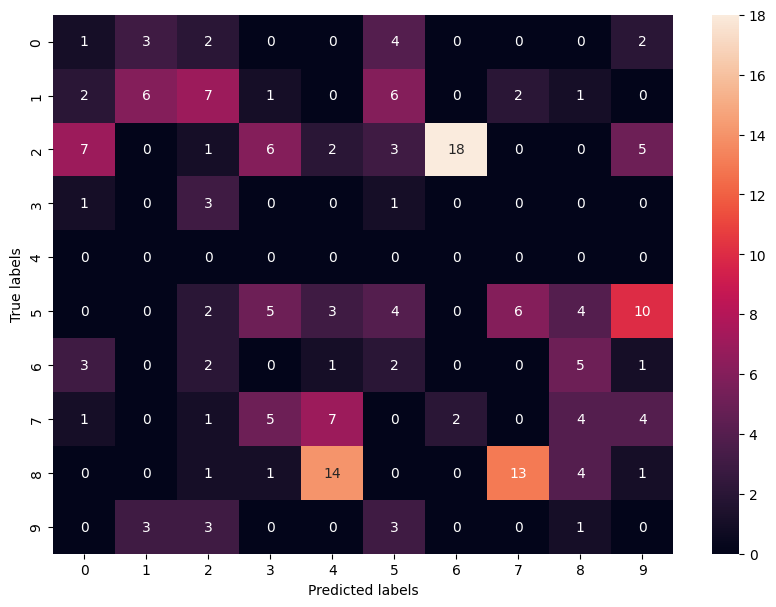

              precision    recall  f1-score   support

           0       0.08      0.07      0.07        15
           1       0.24      0.50      0.32        12
           2       0.02      0.05      0.03        22
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00        27
           5       0.12      0.17      0.14        23
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00        21
           8       0.12      0.21      0.15        19
           9       0.00      0.00      0.00        23

    accuracy                           0.08       200
   macro avg       0.06      0.10      0.07       200
weighted avg       0.05      0.08      0.06       200



/home/jos-evans/.cache/pypoetry/virtualenvs/genre-recognition-PQfsOjYy-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jos-evans/.cache/pypoetry/virtualenvs/genre-recognition-PQfsOjYy-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jos-evans/.cache/pypoetry/virtualenvs/genre-recognition-PQfsOjYy-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with

In [62]:
#train a model using feature_df as the training data, clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


# Select the features to use for clustering
X = features_df.drop(columns=["genre"])
X = scaler.fit_transform(X)

y = features_df["genre"]

#use one hot encoding to encode the genre
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)


#split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)


# Train a KMeans clustering model
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_train)

# Predict the clusters on the test data
y_pred = kmeans.predict(X_test)

#Compute confusion matrix
from sklearn.metrics import confusion_matrix


#display confusio
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

#display score report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))











